Loading and preprocessing data...
Loading datasets...
Original shapes:
Training data shape: (27455, 785)
Test data shape: (7172, 785)

Processed shapes:
X_train shape: (27455, 784)
y_train_onehot shape: (27455, 24)

Visualizing random samples from the training set:


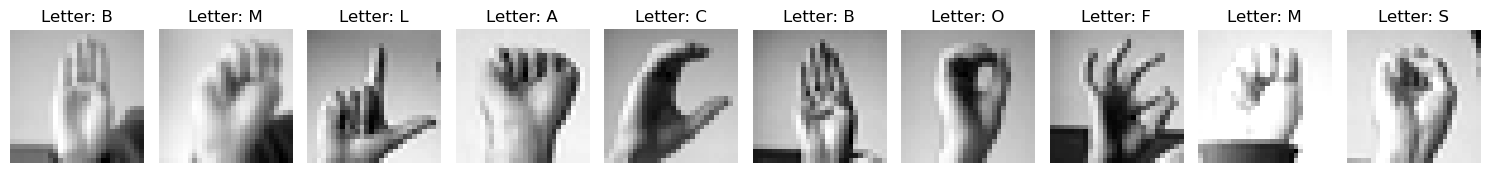


Initializing network parameters...

Training network...
Hidden layers: 256 -> 256 -> 256
Dropout rate: 0.4
Learning rate: 0.1
Batch size: 128
Number of iterations: 300

Iteration 10, Cost: 3.1526, Accuracy: 25.68%
Iteration 20, Cost: 2.4077, Accuracy: 48.22%
Iteration 30, Cost: 1.9170, Accuracy: 64.25%
Iteration 40, Cost: 1.6096, Accuracy: 74.68%
Iteration 50, Cost: 1.4267, Accuracy: 81.26%
Iteration 60, Cost: 1.2888, Accuracy: 85.86%
Iteration 70, Cost: 1.2191, Accuracy: 88.64%
Iteration 80, Cost: 1.1831, Accuracy: 90.30%
Iteration 90, Cost: 1.1636, Accuracy: 91.22%
Iteration 100, Cost: 1.1389, Accuracy: 91.90%
Iteration 110, Cost: 1.1145, Accuracy: 92.59%
Iteration 120, Cost: 1.0798, Accuracy: 93.42%
Iteration 130, Cost: 1.0617, Accuracy: 93.82%
Iteration 140, Cost: 1.0667, Accuracy: 93.91%
Iteration 150, Cost: 1.0557, Accuracy: 93.85%
Iteration 160, Cost: 1.0800, Accuracy: 93.66%
Iteration 170, Cost: 1.0467, Accuracy: 94.21%
Iteration 180, Cost: 1.0417, Accuracy: 94.42%
Iteration 1

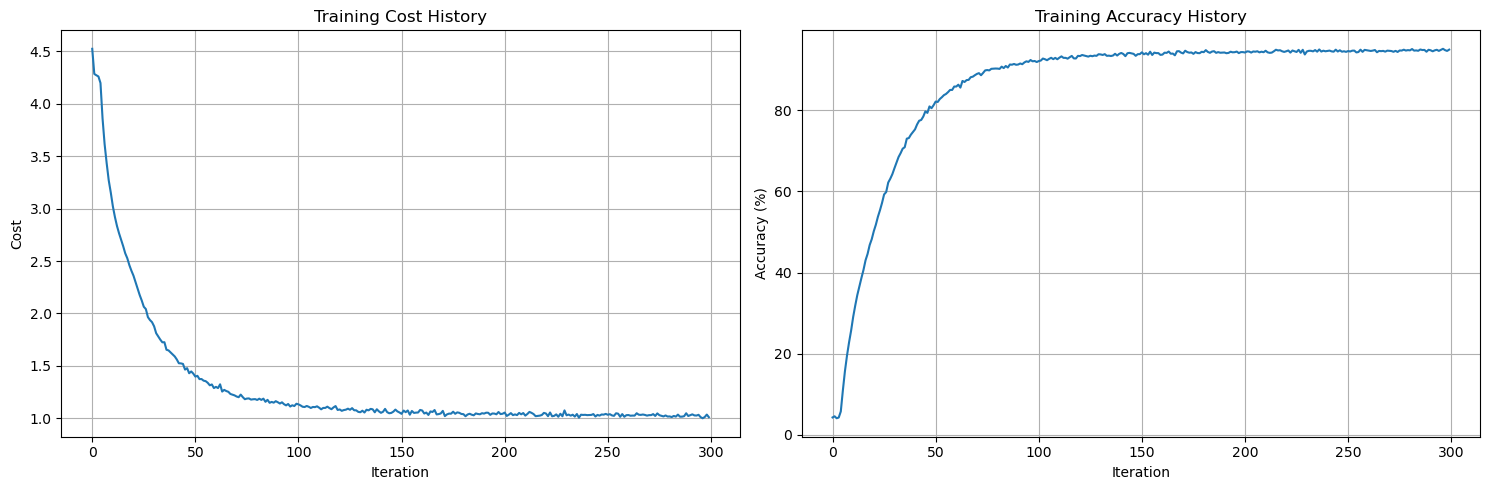


Test set accuracy: 79.21%

Saving model parameters...

Model parameters saved to sign_language_model.json


In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_and_preprocess_data():
    """
    Load and preprocess the Sign Language MNIST dataset
    """
    print("Loading datasets...")
    # Load data and convert to float32 for better performance
    train_data = pd.read_csv('sign_mnist_train.csv')
    test_data = pd.read_csv('sign_mnist_test.csv')

    print("Original shapes:")
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Separate features and labels
    X_train = train_data.drop('label', axis=1).values / 255.0  # Normalize during extraction
    y_train = train_data['label'].values
    X_test = test_data.drop('label', axis=1).values / 255.0
    y_test = test_data['label'].values

    # Convert labels to one-hot encoding
    def to_one_hot(y, num_classes=24):
        one_hot = np.zeros((y.shape[0], num_classes))
        for i, label in enumerate(y):
            # Adjust labels for J(9) and Z(25) exclusion
            if label > 9:  # After J
                label -= 1
            if label > 24:  # After Z
                label -= 1
            one_hot[i, label] = 1
        return one_hot

    y_train_onehot = to_one_hot(y_train)
    y_test_onehot = to_one_hot(y_test)

    print("\nProcessed shapes:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train_onehot shape: {y_train_onehot.shape}")

    return X_train, y_train_onehot, y_train, X_test, y_test_onehot, y_test

def visualize_samples(X, y, num_samples=10):
    """
    Visualize random samples from the dataset
    """
    letters = 'ABCDEFGHIKLMNOPQRSTUVWXY'  # Excluding J and Z

    indices = np.random.randint(0, len(y), num_samples)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        label = y[idx]
        if label > 9:  # After J
            label -= 1
        if label > 24:  # After Z
            label -= 1
        plt.title(f'Letter: {letters[label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def sigmoid(z):
    """
    Compute sigmoid activation function with numerical stability
    """
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_gradient(z):
    """
    Compute gradient of sigmoid function
    """
    s = sigmoid(z)
    return s * (1 - s)

def initialize_network_parameters(input_size=784):
    """
    Initialize neural network with multiple hidden layers using Xavier initialization
    """
    hidden_size1 = 256
    hidden_size2 = 256
    hidden_size3 = 256
    output_size = 24

    Theta1 = np.random.randn(hidden_size1, input_size + 1) * np.sqrt(1. / (input_size + 1))
    Theta2 = np.random.randn(hidden_size2, hidden_size1 + 1) * np.sqrt(1. / (hidden_size1 + 1))
    Theta3 = np.random.randn(hidden_size3, hidden_size2 + 1) * np.sqrt(1. / (hidden_size2 + 1))
    Theta4 = np.random.randn(output_size, hidden_size3 + 1) * np.sqrt(1. / (hidden_size3 + 1))

    return Theta1.astype(np.float32), Theta2.astype(np.float32), \
           Theta3.astype(np.float32), Theta4.astype(np.float32)

def forward_propagate(X, Theta1, Theta2, Theta3, Theta4, dropout_rate=0.4):
    """
    Perform forward propagation with dropout
    """
    m = X.shape[0]
    training = dropout_rate > 0

    # First hidden layer
    a1 = np.hstack([np.ones((m, 1)), X])
    z2 = np.dot(a1, Theta1.T)
    a2 = sigmoid(z2)
    if training:
        mask2 = (np.random.rand(*a2.shape) > dropout_rate)
        a2 *= mask2 / (1 - dropout_rate)
    a2 = np.hstack([np.ones((m, 1)), a2])

    # Second hidden layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    if training:
        mask3 = (np.random.rand(*a3.shape) > dropout_rate)
        a3 *= mask3 / (1 - dropout_rate)
    a3 = np.hstack([np.ones((m, 1)), a3])

    # Third hidden layer
    z4 = np.dot(a3, Theta3.T)
    a4 = sigmoid(z4)
    if training:
        mask4 = (np.random.rand(*a4.shape) > dropout_rate)
        a4 *= mask4 / (1 - dropout_rate)
    a4 = np.hstack([np.ones((m, 1)), a4])

    # Output layer
    z5 = np.dot(a4, Theta4.T)
    a5 = sigmoid(z5)

    return a1, a2, a3, a4, a5, z2, z3, z4, z5

def compute_cost(h, y, Theta1, Theta2, Theta3, Theta4, lambda_reg):
    """
    Compute cost with regularization
    """
    m = y.shape[0]
    epsilon = 1e-15

    # Compute cross-entropy loss
    cost = -1/m * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

    # Add regularization term
    reg_term = (lambda_reg/(2*m)) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2) +
                                    np.sum(Theta3[:,1:]**2) + np.sum(Theta4[:,1:]**2))

    return cost + reg_term

def train_neural_network(X, y, y_original, dropout_rate=0.4, lambda_reg=0.01,
                        alpha=0.1, num_iters=200, batch_size=128):
    """
    Train neural network using mini-batch gradient descent with dropout
    """
    print("\nInitializing network parameters...")
    input_size = X.shape[1]
    m = X.shape[0]

    # Initialize network
    Theta1, Theta2, Theta3, Theta4 = initialize_network_parameters(input_size)

    # Initialize momentum
    v_Theta1 = np.zeros_like(Theta1)
    v_Theta2 = np.zeros_like(Theta2)
    v_Theta3 = np.zeros_like(Theta3)
    v_Theta4 = np.zeros_like(Theta4)
    momentum = 0.9

    # Training history
    cost_history = []
    accuracy_history = []

    print("\nTraining network...")
    print(f"Hidden layers: 256 -> 256 -> 256")
    print(f"Dropout rate: {dropout_rate}")
    print(f"Learning rate: {alpha}")
    print(f"Batch size: {batch_size}")
    print(f"Number of iterations: {num_iters}\n")

    for iteration in range(num_iters):
        # Shuffle data
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]

        batch_costs = []
        batch_accuracies = []

        # Mini-batch processing
        for batch_start in range(0, m, batch_size):
            batch_end = min(batch_start + batch_size, m)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]

            # Forward propagation
            outputs = forward_propagate(X_batch, Theta1, Theta2, Theta3, Theta4, dropout_rate)
            a1, a2, a3, a4, a5, z2, z3, z4, z5 = outputs

            # Backward propagation
            m_batch = X_batch.shape[0]

            # Compute deltas
            delta5 = a5 - y_batch
            delta4 = (np.dot(delta5, Theta4) * np.hstack([np.ones((m_batch, 1)),
                sigmoid_gradient(z4)]))[:, 1:]
            delta3 = (np.dot(delta4, Theta3) * np.hstack([np.ones((m_batch, 1)),
                sigmoid_gradient(z3)]))[:, 1:]
            delta2 = (np.dot(delta3, Theta2) * np.hstack([np.ones((m_batch, 1)),
                sigmoid_gradient(z2)]))[:, 1:]

            # Compute gradients
            Theta4_grad = (1/m_batch) * np.dot(delta5.T, a4)
            Theta3_grad = (1/m_batch) * np.dot(delta4.T, a3)
            Theta2_grad = (1/m_batch) * np.dot(delta3.T, a2)
            Theta1_grad = (1/m_batch) * np.dot(delta2.T, a1)

            # Add regularization
            Theta4_grad[:, 1:] += (lambda_reg/m_batch) * Theta4[:, 1:]
            Theta3_grad[:, 1:] += (lambda_reg/m_batch) * Theta3[:, 1:]
            Theta2_grad[:, 1:] += (lambda_reg/m_batch) * Theta2[:, 1:]
            Theta1_grad[:, 1:] += (lambda_reg/m_batch) * Theta1[:, 1:]

            # Update with momentum
            v_Theta4 = momentum * v_Theta4 - alpha * Theta4_grad
            v_Theta3 = momentum * v_Theta3 - alpha * Theta3_grad
            v_Theta2 = momentum * v_Theta2 - alpha * Theta2_grad
            v_Theta1 = momentum * v_Theta1 - alpha * Theta1_grad

            Theta4 += v_Theta4
            Theta3 += v_Theta3
            Theta2 += v_Theta2
            Theta1 += v_Theta1

            # Compute batch metrics
            cost = compute_cost(a5, y_batch, Theta1, Theta2, Theta3, Theta4, lambda_reg)
            accuracy = np.mean(np.argmax(a5, axis=1) == np.argmax(y_batch, axis=1)) * 100

            batch_costs.append(cost)
            batch_accuracies.append(accuracy)

        # Store average metrics
        avg_cost = np.mean(batch_costs)
        avg_accuracy = np.mean(batch_accuracies)
        cost_history.append(avg_cost)
        accuracy_history.append(avg_accuracy)

        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}, Cost: {avg_cost:.4f}, Accuracy: {avg_accuracy:.2f}%")

    return Theta1, Theta2, Theta3, Theta4, cost_history, accuracy_history

def plot_training_history(cost_history, accuracy_history):
    """
    Plot training metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot cost history
    ax1.plot(cost_history)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')
    ax1.set_title('Training Cost History')
    ax1.grid(True)

    # Plot accuracy history
    ax2.plot(accuracy_history)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training Accuracy History')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def save_model_parameters(Theta1, Theta2, Theta3, Theta4, output_file='model_parameters.json'):
    """
    Save the trained model parameters to a JSON file
    """
    model_params = {
        'Theta1': Theta1.tolist(),
        'Theta2': Theta2.tolist(),
        'Theta3': Theta3.tolist(),
        'Theta4': Theta4.tolist(),
        'input_size': Theta1.shape[1] - 1,
        'hidden_size1': Theta1.shape[0],
        'hidden_size2': Theta2.shape[0],
        'hidden_size3': Theta3.shape[0],
        'output_size': Theta4.shape[0]
    }

    with open(output_file, 'w') as f:
        json.dump(model_params, f)

    print(f"\nModel parameters saved to {output_file}")

if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, y_train_onehot, y_train, X_test, y_test_onehot, y_test = load_and_preprocess_data()

    # Visualize samples
    print("\nVisualizing random samples from the training set:")
    visualize_samples(X_train, y_train)

    # Train the neural network
    Theta1, Theta2, Theta3, Theta4, cost_history, accuracy_history = train_neural_network(
        X_train,
        y_train_onehot,
        y_train,
        dropout_rate=0.4,
        lambda_reg=0.01,
        alpha=0.1,
        num_iters=300,
        batch_size=128
    )

    # Plot training history
    plot_training_history(cost_history, accuracy_history)

    # Evaluate on test set
   # Replace this line:
    # First fix the forward propagation unpacking
    _, _, _, _, h_test, _, _, _, _ = forward_propagate(X_test, Theta1, Theta2, Theta3, Theta4, dropout_rate=0)
    test_predictions = np.argmax(h_test, axis=1)

    # Calculate and print test accuracy
    test_accuracy = np.mean(test_predictions == np.argmax(y_test_onehot, axis=1)) * 100
    print(f"\nTest set accuracy: {test_accuracy:.2f}%")

    # Save the model parameters
    print("\nSaving model parameters...")
    save_model_parameters(Theta1, Theta2, Theta3, Theta4, output_file='sign_language_model.json')
